In [ ]:
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mpllines
from scipy import constants
import unyt as u

from load import load_sheet

In [ ]:
def wein(wl):
    # wl should be in um
    # returns T in K
    b = 2998 # mu.K
    return b / wl

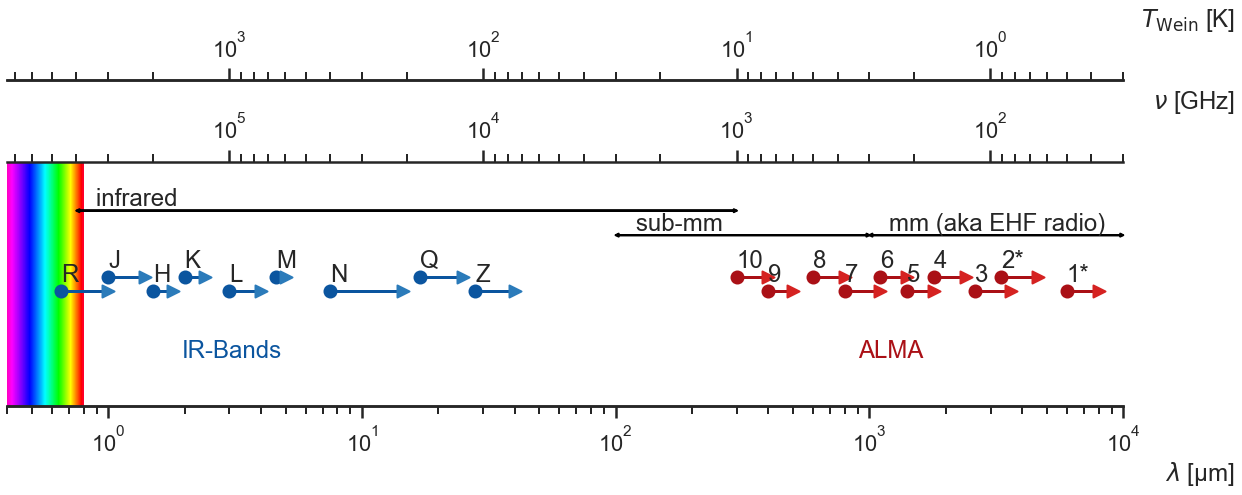

In [12]:
# style
plt.style.use("seaborn")
sns.set(style="ticks")
sns.set_context("poster")

# def
def mum2GHz(arr_mum:np.ndarray) -> np.ndarray:
    return constants.c / arr_mum * 1e-3

# main data struct
datasets = {
    'ALMA': sns.color_palette("Reds"),
    'IR-Bands': sns.color_palette("Blues"),
}
YLIM = (0, 1)

try:
    plt.close(fig)
except NameError:
    pass
def draw_span(ax, xmin:float, xmax:float, y:float=0.8, epsy:float=0.02, name:str="") -> None:
    w = 3
    arrow_style = dict(
        shrink=0.,
        width=w/100,
        headwidth=w,
        headlength=w,
        color="black"
    )
    ax.annotate("", xytext=(xmin, y), xy=(xmax, y), arrowprops=arrow_style)
    ax.annotate("", xytext=(xmax, y), xy=(xmin, y), arrowprops=arrow_style)
    # associated name
    if name:
        ax.annotate(f"   {name}", xytext=(xmin, y+epsy), xy=(xmax, y+epsy))

fig = plt.figure(figsize=(20, 6))
gs = fig.add_gridspec(100, 1)
ax_sec = fig.add_subplot(gs[:25, :])
ax_main = fig.add_subplot(gs[25:, :])

ax = ax_main
powlims = [0, 3]
for sheetname, palette in datasets.items():
    ds = load_sheet(sheetname).T
    lc = palette[-1]
    offsets = [0.5 - 0.03*(-1)**n for n, _ in enumerate(ds)]

    for xkey, color, marker in zip(
                ["lambda min", "lambda max"],
                reversed(palette),
                ['o', '>']
        ):
        ax.scatter(
                x=ds.T[xkey],
                y=offsets,
                color=color,
                marker=marker,
                zorder=2
        )

    for n, band in enumerate(ds):
        wl = [ds[band]["lambda min"], ds[band]["lambda max"]]
        ax.plot(wl, offsets[n]*np.ones(2), color=lc, zorder=1)
        ax.annotate(s=band, xy=[wl[0], offsets[n]+0.04])

    wlrange = min(ds.T["lambda min"]), max(ds.T["lambda max"])
    powlims[0] = min(powlims[0], np.log10(wlrange[0]))
    powlims[1] = max(powlims[1], np.log10(wlrange[1]))

    # display sheet name
    ax.annotate(s=sheetname, xy=[wlrange[0]*3, 0.2], color=palette[-1])
    

# add visible spectrum
xblue = 0.4
xred  = 0.8
xv = np.linspace(xblue, xred, 1000)
yv = np.linspace(*YLIM, 2)
xg, yg = np.meshgrid(xv, yv)
ax.pcolormesh(xg, yg, xg, cmap="gist_rainbow_r", zorder=0, alpha=0.5)

# over plot basic domains
Domain = namedtuple("Domain", "name xmin xmax yoffset")
domains = [
        Domain("infrared", 0.75, 300, 0.8),
        Domain("sub-mm", 1e2, 1e3, 0.7),
        Domain("mm (aka EHF radio)", 1e3, 1e4, 0.7),
]
for d in domains:
    draw_span(ax, xmin=d.xmin, xmax=d.xmax, y=d.yoffset, name=d.name)
xredest = max([d.xmax for d in domains])
xredest = 1e4

# set limits and labels
ax.set_xlim(min(xblue, 0.8*10**powlims[0]), max(1.2*10**powlims[1], xredest))
ax.set_ylim(*YLIM)
ax.set_xlabel(r"$\lambda$ [µm]", horizontalalignment='right', x=1.1)

# secondary x axis for frequencies
axb = ax.twiny()
axb.set_xlim(mum2GHz(np.array(ax.get_xlim())))
axb.set_xlabel(r"$\nu$ [GHz]", horizontalalignment='right', x=1.1)

# scaling
for a in (ax, axb):
    a.set_xscale("log")

ax.set_yticks([])

ax = ax_sec
ax.set_yticks([])

ax_secb = ax.twiny()
ax_secb.set_xlim(wein(np.array(ax_main.get_xlim())))
ax.set_xticks([])
ax_secb.set_xscale("log")
ax_secb.set_xlabel(r"$T_\mathrm{Wein}$ [K]", horizontalalignment='right', x=1.1)
sns.despine(ax=ax, right=True, left=True, top=False, bottom=True)
sns.despine(ax=ax_secb, right=True, left=True, top=False, bottom=True)
ax_secb.tick_params(which="both", top=True)

sns.despine(ax=ax_main, right=True, left=True)
sns.despine(ax=axb, right=True, left=True, top=False)

fig

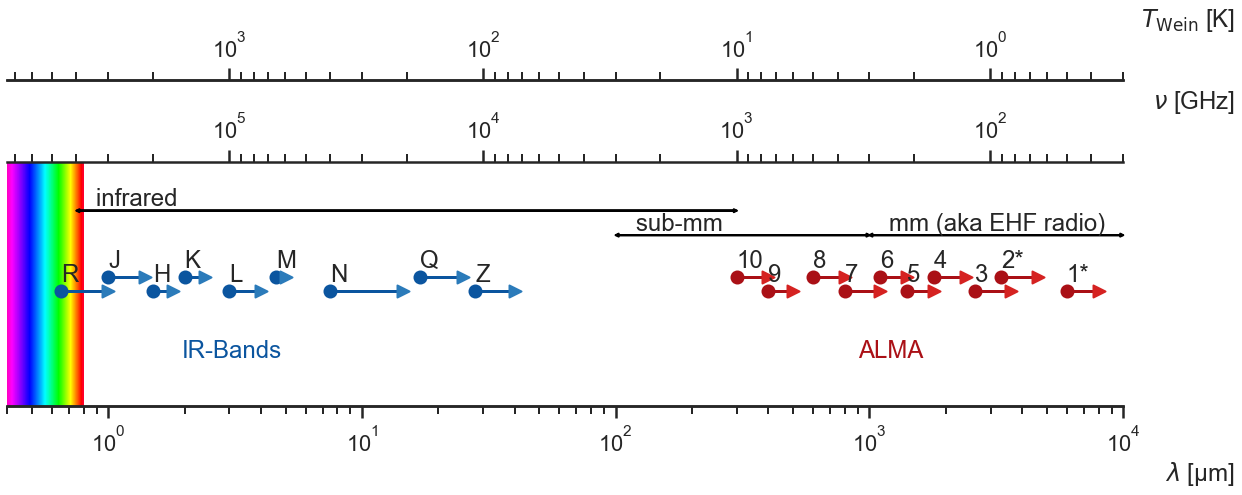

In [13]:
fig.savefig("holymap.pdf", bbox_inches="tight")